# Статистический анализ данных поездок электросамокатов

Требуется проанализииировать данные о поездках пользователей сервиса аренды самокатов и проверить несколько гипотех о поездках пользователей с подпиской и без. А так же рассчитать параметры промо-кампании для достижения поставленных результатов.

Стоимость минуты поездки без подписки - 8 рублей (стоимость старта 50 рублей), с подпиской - 6 рублей (абон плата в месяц 199 рублей).

## Исходные данные
Данные для иссследования представлены тремя файлами:
- Пользователи - users_go.csv
- Поездки — rides_go.csv
- Подписки - subscriptions_go.csv

Легенда:
- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

Краткий план работы
- Загрузим и предобработаем данные, проверим наличие дубликатов и пропусков, при необходимости исправим.
- Затем иссследуем показатели по востребованности самокатов по городам, изучим клиентов и особенности использования самокатов в городах. 
- Объединим данные из таблиц в единый датафрейм для дальнейшей работы и анализа.
- Агрегируем данные, посчитаем основные показатели для каждого пользователя помесячно, Посчитаем выручку. Проанализируем полученные данные.
- Проверим гипотезы от отдела маркетинга.
- Рассчитаем размер необходимой рассылки промокодов и push-сообщений.

In [1]:
# Яндекс Практикум проект

## Загрузка данных
Но перед этим сделаем импорт необходимых библиотек и провдем настройки Jupyter Notebook.

In [2]:
# Игнгорирование предупреждений системы
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [3]:
# Импорт необходимых билиотек
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

In [4]:
# Загрузим данные
users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv') #пользователи
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv') #поездки
subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv') #подписки

Краткое изучение полученных данных.

Пользователи.

In [5]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Пропусков нет, хорошо. 1565 строк.

Поездки.

In [6]:
rides.info()
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Пропусков нет. 18068 строк. Есть колонка с датой - загружаем в виде даты.

In [7]:
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', parse_dates=['date']) #поездки
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Условия подписки.

In [8]:
subscriptions.info()
subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Пропусков нет.

## Предобработка данных

Смотрим за какой период представлены данные о поездках

In [9]:
rides.date.min(), rides.date.max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-12-30 00:00:00'))

В таблице данные по поездкам за 2021 год, агрегация по месяцам будет корректной

Создаем колонку с месяцем поездки, проверяем.

In [10]:
rides['month'] = rides.date.dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверяем на пропуски и дубликаты.

In [11]:
print(rides.isna().sum())
print(users.isna().sum())
print('Количество полных дубликатов:', users.duplicated().sum())

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
Количество полных дубликатов: 31


Удалим дубликаты - оставляем первые значения, сбрасываем индексы, проверяем.

In [12]:
users.drop_duplicates(keep='first', inplace=True)
users.reset_index(drop=True)
print('Количество полных дубликатов:', users.duplicated().sum())

Количество полных дубликатов: 0


In [13]:
print('Количество полных дубликатов:', rides.duplicated().sum())

Количество полных дубликатов: 0


Во второй таблице дубликатов нет.

## Исследовательский анализ данных

### Количество поездок в городах

             city  count   freq
0       Пятигорск    219  0.143
1    Екатеринбург    204  0.133
2  Ростов-на-Дону    198  0.129
3       Краснодар    193  0.126
4            Сочи    189  0.123
5            Омск    183  0.119
6          Тюмень    180  0.117
7          Москва    168  0.110


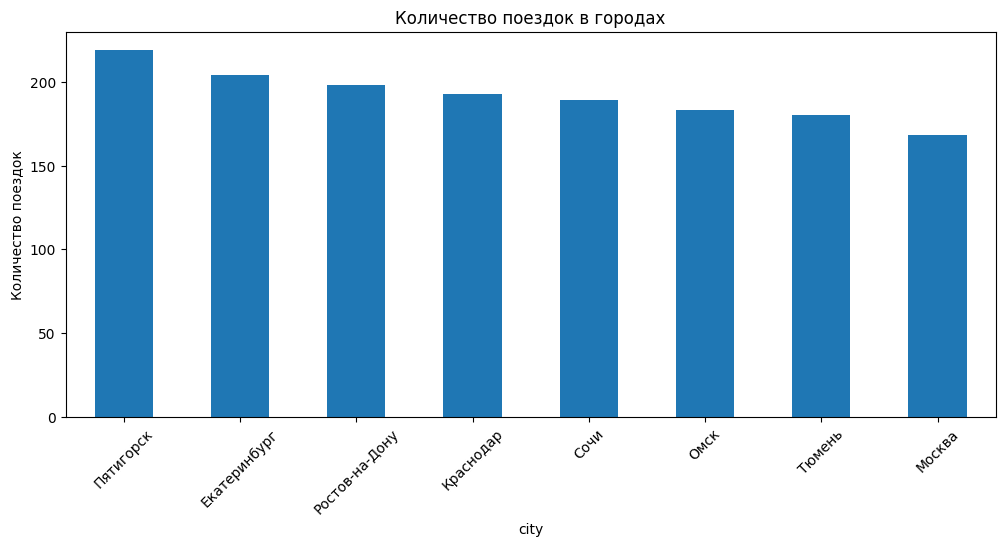

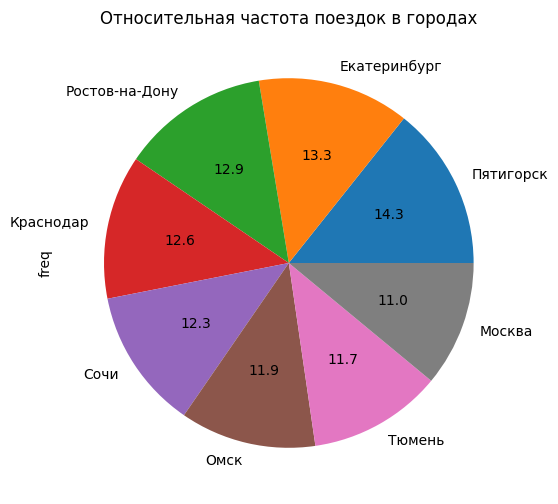

In [14]:
all = users.user_id.count()
cityes = users.pivot_table(index=['city'], values='user_id', aggfunc='count')
cityes.rename(columns={'user_id': 'count'}, inplace=True)
cityes['freq'] = round(cityes/all, 3)
cityes = cityes.reset_index()
cityes = cityes.sort_values(by='freq', ascending=False).reset_index(drop=True)
print(cityes)
cityes.plot(kind='bar', x='city', y=['count'], rot=45, figsize=(12,5), 
            title='Количество поездок в городах', grid = False, legend=False, ylabel='Количество поездок');
cityes.plot(kind='pie', y='freq', x='freq', figsize=(6,6), labels=cityes.city,
            title='Относительная частота поездок в городах', grid = False, legend=False, autopct = '%.1f');

plt.show()

Чаще всего самокатами пользуются в Пятигорске, меньше всего - в Москве.

### Соотношение пользователей с подпиской и без

In [15]:
users.groupby('subscription_type').agg({'user_id':'count'})

,user_id
subscription_type,
free,835
ultra,699


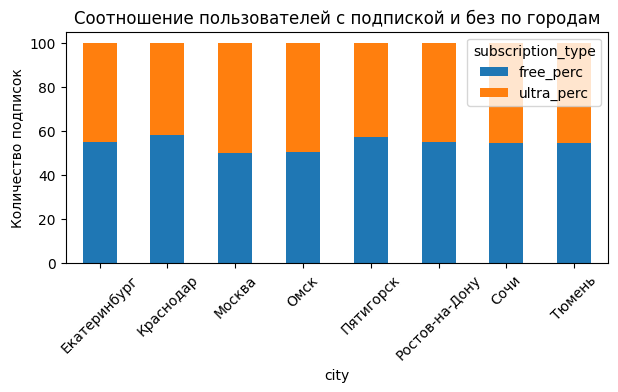

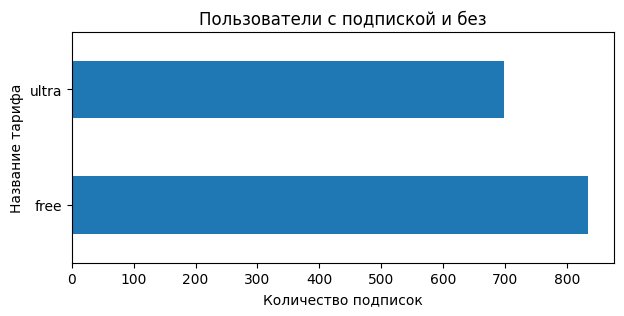

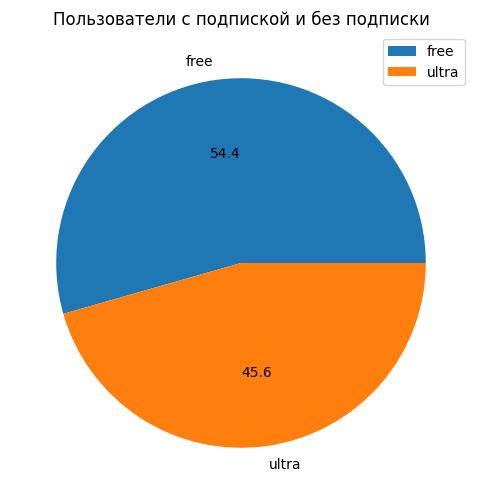

In [16]:
subscriptions_users = users.pivot_table(index=['city'], columns='subscription_type', values='user_id', aggfunc='count').reset_index()
subscriptions_users['summ'] = subscriptions_users.free + subscriptions_users.ultra
subscriptions_users['free_perc'] = round(subscriptions_users.free/subscriptions_users.summ * 100, 2)
subscriptions_users['ultra_perc'] = round(subscriptions_users.ultra/subscriptions_users.summ * 100, 2)
subscriptions_users

subscriptions_users.plot(kind='bar', x='city', y=['free_perc', 'ultra_perc'], figsize=(7,3), ylabel='Количество подписок', 
            rot=45, stacked=True, title='Соотношение пользователей с подпиской и без по городам')
users.groupby('subscription_type').agg({'user_id':'count'}).reset_index().plot(kind='barh', 
            legend=False, x='subscription_type', ylabel='Название тарифа', 
            xlabel='Количество подписок', figsize=(7,3), title='Пользователи с подпиской и без')
plt.show()

users.groupby('subscription_type').agg({'user_id':'count'}).plot(kind='pie', y='user_id', 
            legend=True, ylabel='', 
            figsize=(6, 6), title='Пользователи с подпиской и без подписки', autopct = '%.1f')
plt.show()

На данный момент подписка есть у 46% пользователей сервиса аренды самокатов.

### Возраст пользователей

In [17]:
users.age.describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

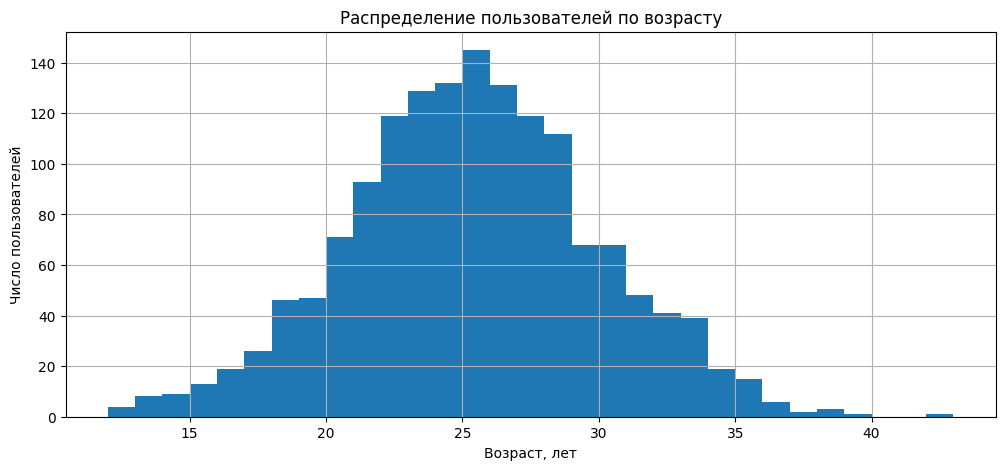

In [18]:
bins = users.age.max() - users.age.min()

users.age.plot(kind='hist', bins=bins, figsize=(12,5), grid=True,
              title='Распределение пользователей по возрасту', 
                    xlabel='Возраст, лет', ylabel='Число пользователей')
plt.show()

**Вывод:** Средний возраст пользователей сервиса - люди в возрасте 25 лет плюс минус 5 лет. Это ядро аудитории.

### Расстояние, которое пользователь преодолел за одну поездку; ###

In [19]:
rides.pivot_table(index='user_id', values='distance', aggfunc='mean')[:10]

,distance
user_id,
1,2839.181839
2,3087.641692
3,3075.633155
4,3202.656423
5,3232.449968
6,3407.860669
7,3044.217447
8,3150.852291
9,2966.367784


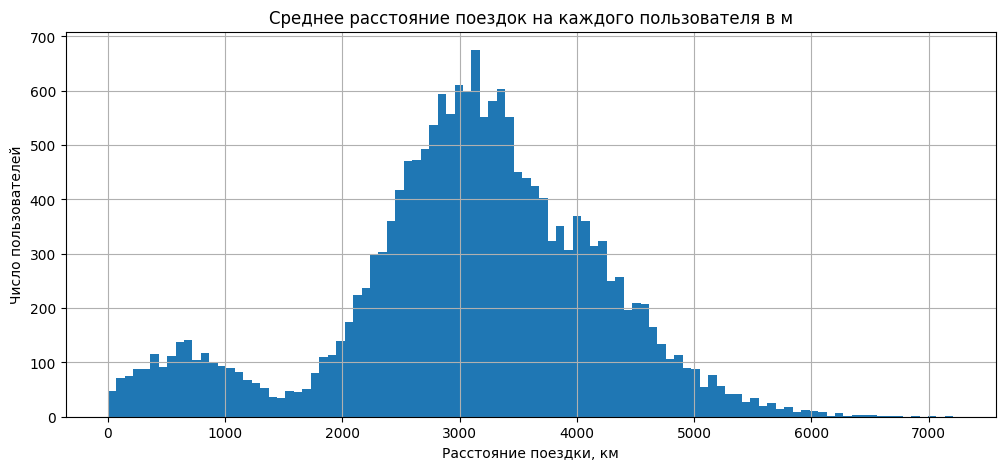

In [20]:
rides.distance.plot(kind='hist', bins=100, figsize=(12, 5),
                    title='Среднее расстояние поездок на каждого пользователя в м', 
                    xlabel='Расстояние поездки, км', ylabel='Число пользователей', grid=True)
plt.show()

In [21]:
rides.distance.describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

В среднем пользователь проезжает около 3 км. Плюс-минус 1 км. Есть интересный сегмент на графике - первый пик поездок до 1 км. Можно выделить этот сегмент пользователей и попробовать с ними отдельно поработать. Можно поизучать есть ли такая тенденция по всем городам или только в определенных Возможно это связано с расположением точек аренды и особенностей конкретной территории.

### Продолжительность поездок

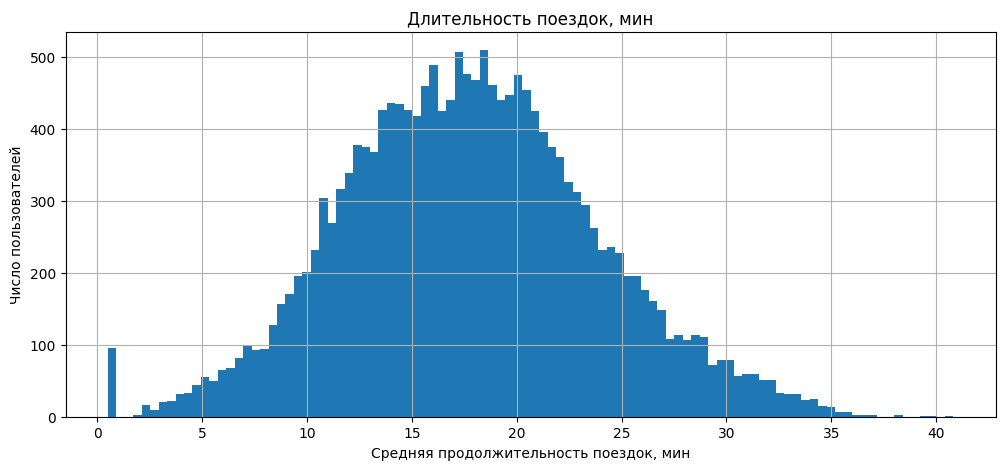

In [22]:
rides.duration.plot(kind='hist', bins=100, figsize=(12, 5), title='Длительность поездок, мин', 
                    xlabel='Средняя продолжительность поездок, мин', ylabel='Число пользователей', grid=True)
plt.show()

In [23]:
rides.duration.describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Средняя длительность одной поездки - около 17 минут. Плюс-минус 6 минут - от 10 до 25 минут. 

### Объединение данных

Объединяем данные из трех фреймов в один, проверяем.

In [24]:
df = users.copy()
df = df.merge(rides, on='user_id')
df = df.merge(subscriptions, on='subscription_type')
df.head(15)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Проверяем на дубли и пропуски

In [25]:
print('Дубликатов:', df.duplicated().sum())
print(df.isna().sum())

Дубликатов: 0
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Выделим фреймы по наличию у пользователя подписки.

In [26]:
df_free = df[df['subscription_type']=='free']
df_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [27]:
df_ultra = df[df['subscription_type']=='ultra']
df_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Построим распределение времени поездок.

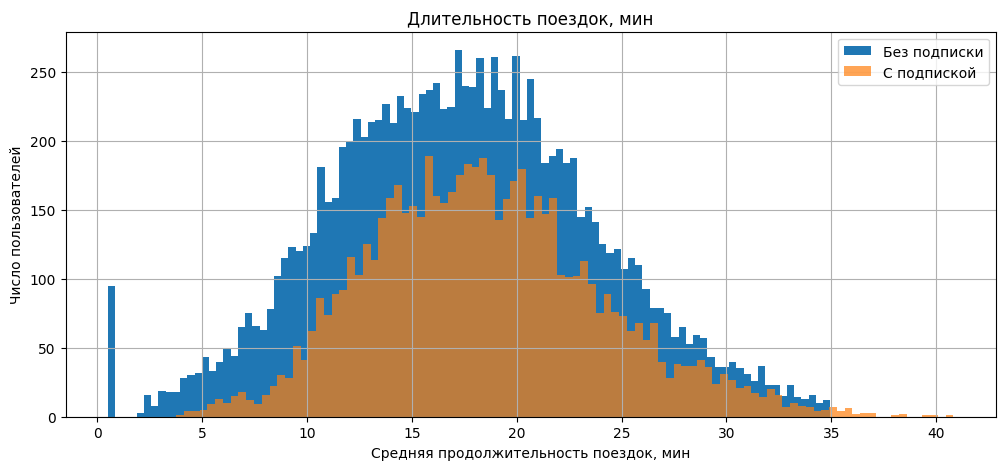

In [28]:
ax = df_free.duration.plot(kind='hist', bins=100, title='Длительность поездок, мин', figsize=(12,5), label='Без подписки',
                    xlabel='Средняя продолжительность поездок, мин', ylabel='Число пользователей', grid=True,
                    )
df_ultra.duration.plot(ax=ax, kind='hist', bins=100, title='Длительность поездок, мин', alpha=0.7, label='С подпиской',
                    xlabel='Средняя продолжительность поездок, мин', ylabel='Число пользователей', grid=True)
plt.legend()
plt.show()

Распределение расстояния поездок.

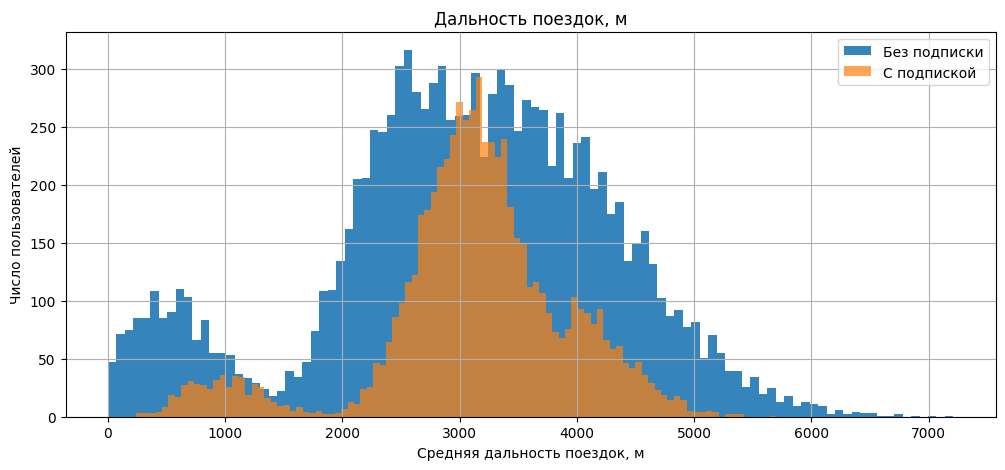

In [29]:
ax = df_free.distance.plot(kind='hist', bins=100, title='Дальность поездок, м', alpha=0.9, figsize=(12, 5),
                    xlabel='Средняя дальность поездок, м', ylabel='Число пользователей', grid=True, label='Без подписки')
df_ultra.distance.plot(ax=ax, kind='hist', bins=100, title='Дальность поездок, м', alpha=0.7, label='С подпиской',
                    xlabel='Средняя дальность поездок, м', ylabel='Число пользователей', grid=True)
plt.legend()
plt.show()

Распределения средней продолжтительности поездок похожи. У дальности поездок есть отличающиеся пики.

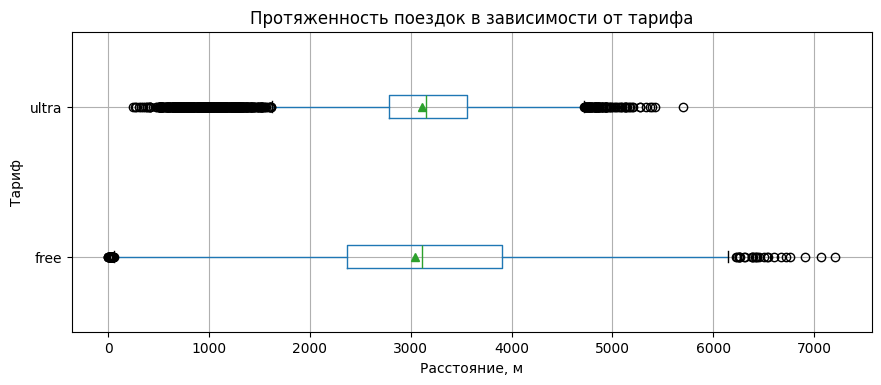

In [30]:
ax = df.boxplot(column='distance', by='subscription_type',
                 showmeans=True, showcaps=True, 
                  showbox=True, vert=False,
                  figsize=(10,4),
                 )
plt.title('Протяженность поездок в зависимости от тарифа')
plt.suptitle('')
plt.ylabel('Тариф')
plt.xlabel('Расстояние, м')
plt.show()

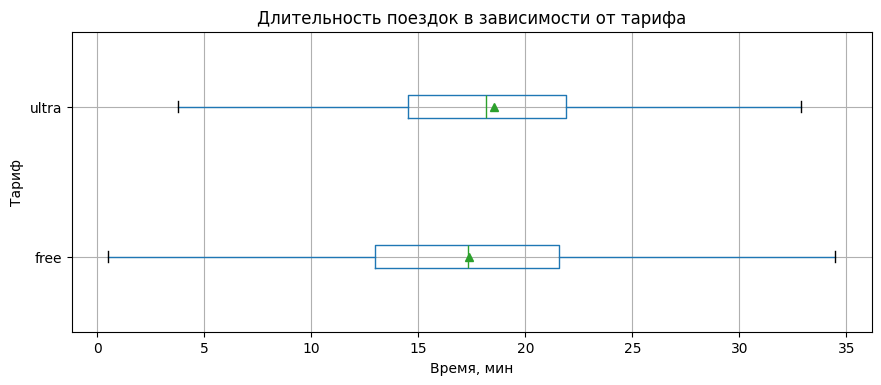

In [31]:
ax = df.boxplot(column='duration', by='subscription_type',
                 showmeans=True, showcaps=True, 
                  showbox=True, showfliers=False, 
                  vert=False, figsize=(10,4),
                 )
plt.title('Длительность поездок в зависимости от тарифа')
plt.suptitle('')
plt.ylabel('Тариф')
plt.xlabel('Время, мин')
plt.show()

**Вывод:** Средняя продолжительность поездок у пользователей с подпиской - выше. 

## Подсчёт выручки

Посчитаем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
Округлим длительность поездок до поплной минуты.

In [32]:
df['duration'] = np.ceil(df['duration']) 

In [33]:
df_grouped = (pd.pivot_table(df, index=['user_id', 'month', 'city'], 
                        aggfunc=({'distance':['count', 'sum'], 
                                  'duration':'sum', 
                                  'subscription_type':['first'], 
                                  'minute_price': ['first'],
                                  'start_ride_price': ['first'],
                                  'subscription_fee': ['first']
                                 }))
          .droplevel(1, axis=1)
          .reset_index()
         )
df_grouped.columns = ['user_id', 'month', 'city', 'quantity', 'distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type']
df_grouped.head(15)

,user_id,month,city,quantity,distance,duration,minute_price,start_ride_price,subscription_fee,subscription_type
0,1,1,Тюмень,2,7027.511294,42.0,6,0,199,ultra
1,1,4,Тюмень,1,754.159807,7.0,6,0,199,ultra
2,1,8,Тюмень,2,6723.470560,46.0,6,0,199,ultra
3,1,10,Тюмень,2,5809.911100,32.0,6,0,199,ultra
4,1,11,Тюмень,3,7003.499363,56.0,6,0,199,ultra
5,1,12,Тюмень,2,6751.629942,28.0,6,0,199,ultra
6,2,3,Омск,3,10187.723006,63.0,6,0,199,ultra
7,2,4,Омск,2,6164.381824,40.0,6,0,199,ultra
8,2,6,Омск,1,3255.338202,14.0,6,0,199,ultra
9,2,7,Омск,2,6780.722964,48.0,6,0,199,ultra


In [34]:
df_grouped.duplicated().sum()
df_grouped.isna().sum()

user_id              0
month                0
city                 0
quantity             0
distance             0
duration             0
minute_price         0
start_ride_price     0
subscription_fee     0
subscription_type    0
dtype: int64

Считаем помесячную выручку по каждому клиенту

In [35]:
df_grouped['revenue'] = df_grouped.start_ride_price * df_grouped.quantity + df_grouped.minute_price * df_grouped.duration + df_grouped.subscription_fee
df_grouped.head()

,user_id,month,city,quantity,distance,duration,minute_price,start_ride_price,subscription_fee,subscription_type,revenue
0,1,1,Тюмень,2,7027.511294,42.0,6,0,199,ultra,451.0
1,1,4,Тюмень,1,754.159807,7.0,6,0,199,ultra,241.0
2,1,8,Тюмень,2,6723.470560,46.0,6,0,199,ultra,475.0
3,1,10,Тюмень,2,5809.911100,32.0,6,0,199,ultra,391.0
4,1,11,Тюмень,3,7003.499363,56.0,6,0,199,ultra,535.0


Выручка по тарифам и городам.

In [36]:
revenue_city = pd.pivot_table(df_grouped, index=['subscription_type'], columns='city', aggfunc=({'revenue':'sum'})).T.reset_index()
revenue_city.drop(['level_0',], axis=1, inplace=True)
revenue_city

subscription_type,city,free,ultra
0,Екатеринбург,307378.0,222613.0
1,Краснодар,293930.0,195515.0
2,Москва,228046.0,180703.0
3,Омск,239796.0,209620.0
4,Пятигорск,325056.0,215646.0
5,Ростов-на-Дону,299786.0,220542.0
6,Сочи,277572.0,203765.0
7,Тюмень,262540.0,196133.0


Построим в виде диаграммы

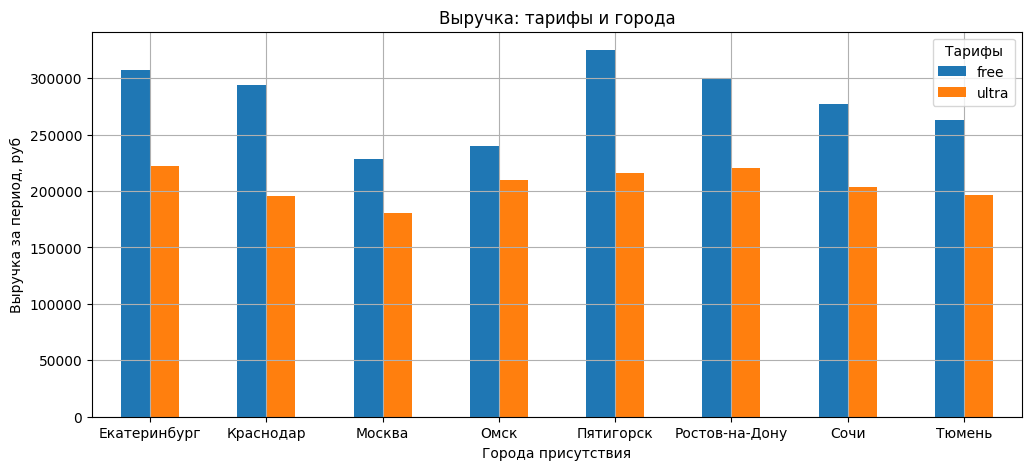

In [37]:
revenue_city.plot(kind='bar', x='city', rot=0, figsize=(12, 5), xlabel='Города присутствия', ylabel='Выручка за период, руб',
                 grid=True, title='Выручка: тарифы и города')
plt.legend(title='Тарифы')
plt.show()

Можно наглядно увидеть распределение выручки по городам от пользователей с подпиской и без.

## Проверка гипотез
### 1. Подписчики проезжают дольше
Выясним тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим. Выделим в отдельные дататсеты суммарную длительность поездок каждого пользователя по разным тарифам. И построим диаграммы.

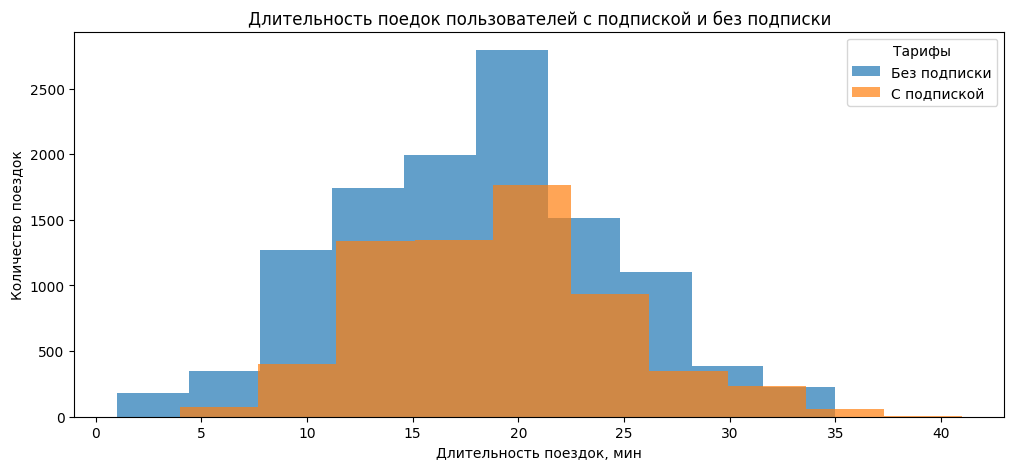

In [38]:
free_duration = df[df.subscription_type == 'free']['duration']
ultra_duration = df[df.subscription_type == 'ultra']['duration']

free_duration.plot(kind='hist', figsize=(12,5), xlabel='Длительность поездок, мин', ylabel='Количество поездок', alpha=0.7,
                  title='Длительность поедок пользователей с подпиской и без подписки', legend=True, label='Без подписки',)
ultra_duration.plot(kind='hist', figsize=(12,5), xlabel='Длительность поездок, мин', ylabel='Количество поездок', alpha=0.7,
                  title='Длительность поедок пользователей с подпиской и без подписки', legend=True, label='С подпиской',)
plt.legend(title='Тарифы')
plt.show()
# Контроль - построим гистограммы

Формулируем гипотезы. H0 - выборки не отличаются. H1 -  пользователи тарифа ultra тратят больше времени. 
Нам нужен двухвыборочный тест для независимых выборок, правосторонняя гипотеза - ttest_ind()

In [39]:
print('Среднее время пользователей с подпиской ultra:', round(ultra_duration.mean(), 2))
print('Среднее время пользователей без подписки:', round(free_duration.mean(), 2))
alpha = 0.05
# проверяем что среднее первой выборки больше. 
print('Проверим, что ultra_duration больше free_duration')
results = st.ttest_ind(ultra_duration, free_duration, alternative='greater')
print('p-value:', results.pvalue)
(print('pvalue < alpha - Нулевая гипотеза отвергается') 
 if results.pvalue < alpha 
 else print('pvalue > alpha - Не получилось отвергнуть нулевую гипотезу'))

Среднее время пользователей с подпиской ultra: 19.04
Среднее время пользователей без подписки: 17.89
Проверим, что ultra_duration больше free_duration
p-value: 2.495945372073663e-34
pvalue < alpha - Нулевая гипотеза отвергается


**Вывод:** Отвергаем нулевую гипотезу в пользу альтернативной. Пользователи с подпиской тратят больше времени на поездку.

### 2. Подписчики проезжают больше
Еще одна гипотеза - Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров (расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката)? 
Формулируем гипотезы. H0 - среднее расстояние пользователей с подпиской равно 3130 м. H1 - пользователи тарифа ultra проезжают больше этого расстояния за поездку. Нам нужен одновыборочный тест, правосторонняя гипотеза - ttest_1samp()

In [40]:
ultra_distance = df[df.subscription_type == 'ultra']['distance']
value = 3130
print('Среднее расстояние в тарифе ultra:', round(ultra_distance.mean(), 2), 'м')
alpha = 0.05 # Уровень значимости.
print('Проверим, что ultra_distance больше', value, 'м')
results = st.ttest_1samp(ultra_distance, value, alternative='greater')
print('p-value:', results.pvalue)
(print('p-value < alpha - Нулевая гипотеза отвергается') 
 if results.pvalue < alpha 
 else print('p-value > alpha - Не получилось отвергнуть нулевую гипотезу'))

Среднее расстояние в тарифе ultra: 3115.45 м
Проверим, что ultra_distance больше 3130 м
p-value: 0.9195368847849785
p-value > alpha - Не получилось отвергнуть нулевую гипотезу


**Вывод:** Результаты теста не позволяют отвергнуть нулевую гипотезу, не оснований, говорить что пользователи с подпиской проезжают больше оптимального расстояния.

### 3. Выручка от подписчиков больше
Проверим, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Разобъем датафрейм на 2 и для наглядноссти построим гистограмы.

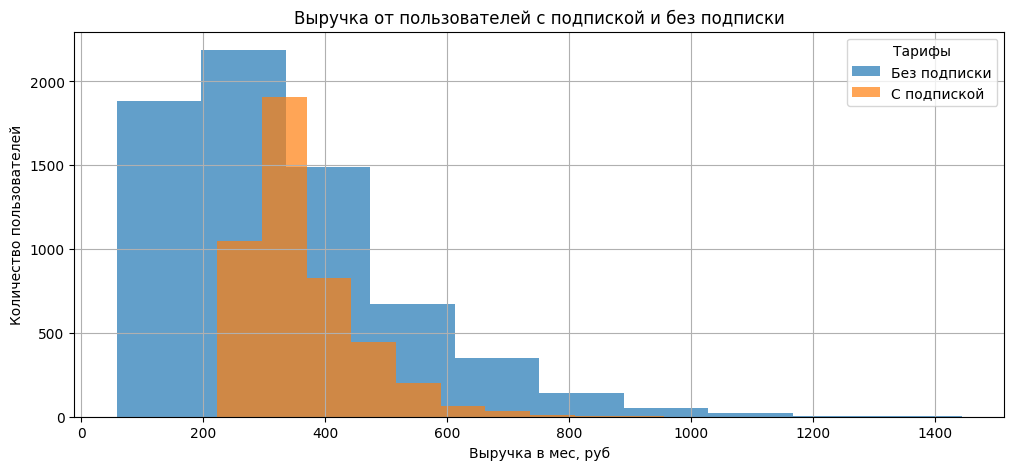

In [41]:
ultra_revenue = df_grouped[df_grouped.subscription_type == 'ultra']['revenue']
free_revenue = df_grouped[df_grouped.subscription_type == 'free']['revenue']

free_revenue.plot(kind='hist', figsize=(12,5), xlabel='Выручка в мес, руб', ylabel='Количество пользователей', alpha=0.7,
                  title='Выручка от пользователей с подпиской и без подписки', legend=True, label='Без подписки', )
ultra_revenue.plot(kind='hist', figsize=(12,5), xlabel='Выручка в мес, руб', ylabel='Количество пользователей', alpha=0.7,
                  title='Выручка от пользователей с подпиской и без подписки', legend=True, label='С подпиской', grid=True)
plt.legend(title='Тарифы')
plt.show()

Формулируем гипотезы. H0 - помесячная выручка в группах с подпиской и без подписки одинаковая. H1 - помесячная выручка от пользователей с подпиской выше. Нам нужен двухвыборочный тест для независимых выборок, правосторонняя гипотеза - ttest_ind() (проверяем что среднее первой выборки больше)

In [42]:
print('Средняя помесячная выручка от пользователей с подпиской ultra:', round(ultra_revenue.mean(), 2))
print('Средняя помесячная выручка от пользователей без подписки:', round(free_revenue.mean(), 2))
alpha = 0.05
print('Проверим, что ultra_revenue больше free_revenue')
results = st.ttest_ind(ultra_revenue, free_revenue, alternative='greater')
print('p-value:', results.pvalue)
(print('p-value < alpha - Нулевая гипотеза отвергается') 
 if results.pvalue < alpha 
 else print('p-value > alpha - Не получилось отвергнуть нулевую гипотезу'))

Средняя помесячная выручка от пользователей с подпиской ultra: 362.79
Средняя помесячная выручка от пользователей без подписки: 328.64
Проверим, что ultra_revenue больше free_revenue
p-value: 1.8850394384715216e-31
p-value < alpha - Нулевая гипотеза отвергается


По результатам проверки выяснии, что выручка от пользователей с подпиской статистически значимо больше чем от пользователей без подписки.

## Расчет маркетинговых маркетинговых активностей.

### 1. Рассчитать параметры рассылки.
Задача - провести кцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Известно, что подписку продлевают 10% пользователей. Нужно рассчитать какое минимальное количество промокодов нужно раздать чтобы вероятность не выполнить план была примерно 5%. Построим график распределения и посчтаем необходимое количество промокодов.

Данный случай описывает биноминальное распределение вероятности - подписку либо оформят либо нет. Есть заявленная вероятность события.  построим график биноминального  распределения для 1000 промокодов

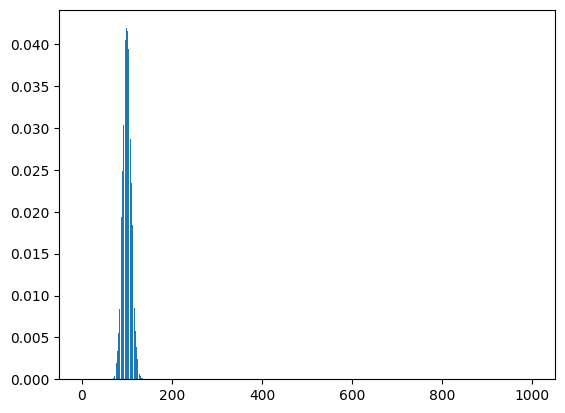

Среднее и дисперсия: (100.0, 90.0)


In [43]:
from math import sqrt
n, p = 1000, 0.1
distr = [st.binom.pmf(r, n, p) for r in range(n+1) ] 
plt.bar(range(0, n+1), distr)
plt.show()
print('Среднее и дисперсия:', st.binom.stats(n, p))

In [44]:
n = 1170
p = 0.1
distr = st.binom(n=n, p=p)
prob = 0.05 # заданная вероятность
min_clients = 100 # минимальное количество клиентов
new_clients = int(distr.ppf(prob))
print('При заданной вероятности', prob,
      'при рассылке', n, 'промокодов',
      'подпишутся', new_clients, 'клиентов')

При заданной вероятности 0.05 при рассылке 1170 промокодов подпишутся 100 клиентов


**Вывод:** нужно разослать не мемнее 1170 промокодов.

### 2. Рассчитать вероятность прочтения.
Килентам рассылаются push-уведомления в мобильном приложении. По статистике их открывают около 40% получивших. В планах разослать 1 млн. уведомлений. Нужно найти вероятность того, что уведомления открют не более 399б5 тыс пользователей.

Оценку вероятности можно провести с помощью функции cdf. Оценивать будем по аппроксимации функции к нормальному распределению.

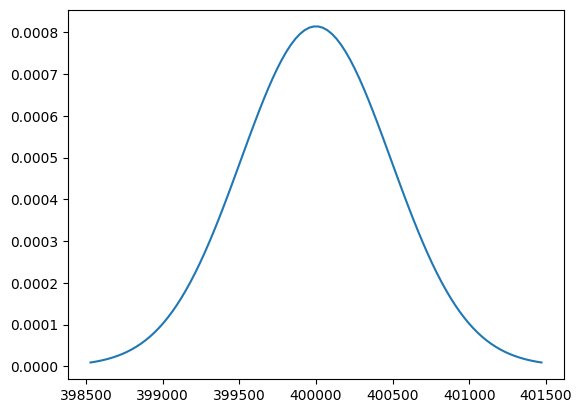

Вероятность того, что уведомление откроют не более 399500 человек составляет: 15.37%


In [45]:
p = 0.4
n = 1000000
min_n = 399500
mu = n * p
sigma = (n * p * (1 - p))**0.5
distr = st.norm(mu, sigma)
# distr.hist()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, st.norm.pdf(x, mu, sigma))
plt.show()
prob = distr.cdf(min_n)
print('Вероятность того, что уведомление откроют не более', min_n, f'человек составляет: {prob:.2%}')

**ОБЩИЙ ВЫВОД:** 

По результатам исследования были получены следующие выводы.
- Были проанализированы данные о 1,5 тыс пользователей из 8 городов, где работает сервис проката за 2021 год.
- За год пользователями было совершено 18 тыс. поездок. Больше всего поездок было совершено в Пятгигорске (219), меньше вссего - в Москве (168).
- Пользователей, которые пользуются сервисом по подписке- 46%. В относительных долях больше всего подписчиков - в Москве (50%), меньше всего - в Краснодаре (42%).
- Средний возраст пользователей сервиса - 25 лет плюс-минус 5 лет. Это ядро аудитории.
- За одну поездку пользователь в среднем проезжает около 3 км плюс-минус 1 км.
- Время одной поездки колеблется от 10 до 25 минут (среднее около 17 минут).
- Отличия по категориям пользователей  с подпиской и без подписки:
- Средняя продолжительность поездок у пользователей с подпиской - выше. В среднем обе категории проезжают 3 км за поездку.
- Была рассчитана выручка и построены графики ее распределения по городам и тарифам. наибольшая выручка - в Пятигорске на тарифе free (325 тыс. руб.), наименьшая - Москва (181 тыс. руб.) тариф ultra.
- Пользователи с подпиской тратят в среднем больше времени на поездку. ~~При этом проезжают за поездку проезжают расстояние меньшее оптимального (для износа)~~. Помесячная выручка от пользователей с подпиской выше чем от пользователлей без подписки. Поскольку подписчики по всем параметрам выгоднее компании, то нужно направить усилия на увеличение их количества.